Common genes: ['ACTB', 'NFKBIA']
Time points/replicates: 12 per condition
ACTB: Similarity = 0.9994 (distance: 0.0006)
NFKBIA: Similarity = 0.9873 (distance: 0.0127)

Summary:
Mean similarity: 0.993
Std deviation: 0.006
Min similarity: 0.987 (NFKBIA)
Max similarity: 0.999 (ACTB)


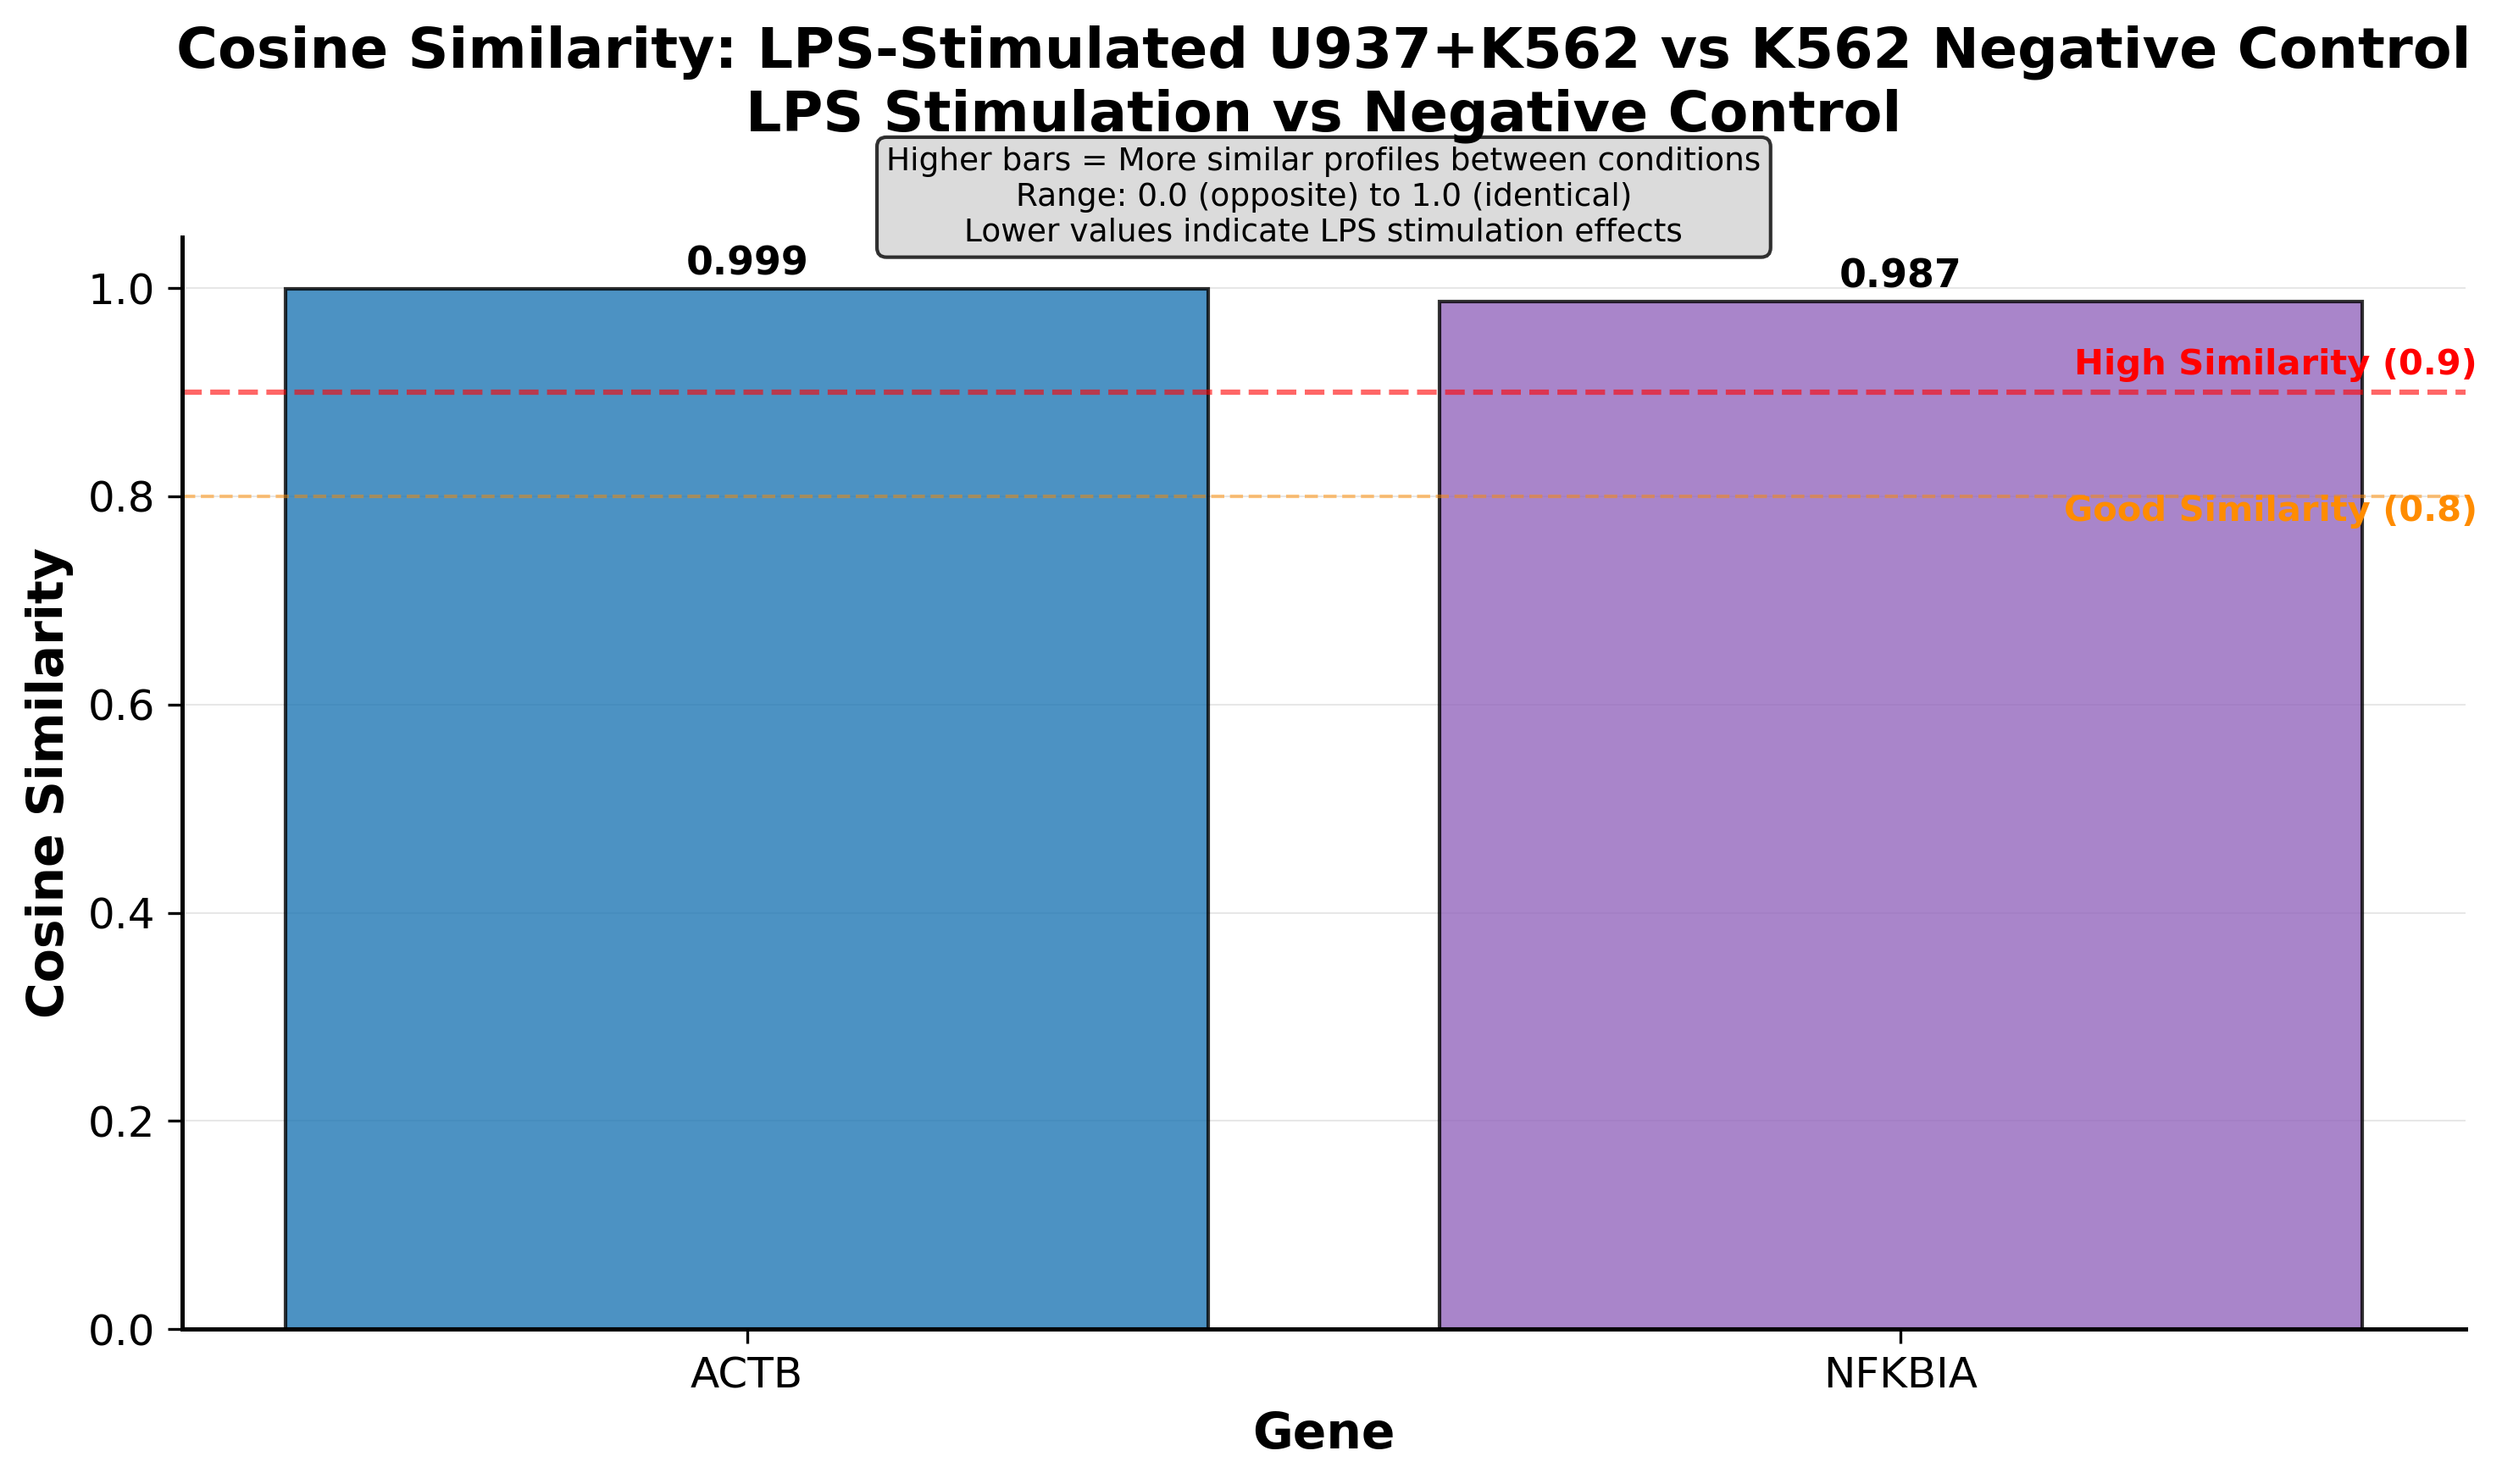


Plot saved as: lps_stim_vs_negctrl_cosine_similarity_lps_stimulation_vs_negative_control.svg


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

def create_cosine_similarity_bar_chart(cosine_similarities_dict, title_suffix, save_filename='cosine_similarity_bar_chart.svg'):
    """
    Create a publication-quality bar chart of cosine similarities between two conditions.

    Parameters:
    cosine_similarities_dict: dict with gene names as keys and cosine similarities as values
    title_suffix: string to customize the plot title
    save_filename: string, filename to save the plot
    """
    # Set publication style parameters
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'Arial',
        'axes.linewidth': 1.2,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight'
    })

    # Gene colors for consistency
    gene_colors = {
        'ACTB': '#1f77b4',    # Blue - housekeeping
        'ICAM1': '#ff7f0e',   # Orange
        'IER3': '#2ca02c',    # Green
        'IL8': '#d62728',     # Red
        'NFKBIA': '#9467bd',  # Purple
        'TNFRSF9': '#8c564b'  # Brown
    }

    # Extract data for plotting
    genes = list(cosine_similarities_dict.keys())
    similarities = list(cosine_similarities_dict.values())
    colors = [gene_colors.get(gene, '#808080') for gene in genes]  # Default gray if unknown gene

    # Create the figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Create the bar chart
    bars = ax.bar(genes, similarities, color=colors, alpha=0.8, 
                  edgecolor='black', linewidth=1)

    # Add value labels on top of bars
    for i, (bar, similarity) in enumerate(zip(bars, similarities)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{similarity:.3f}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

    # Customize the plot
    ax.set_ylabel('Cosine Similarity', fontsize=14, fontweight='bold')
    ax.set_xlabel('Gene', fontsize=14, fontweight='bold')
    ax.set_title(f'Cosine Similarity: LPS-Stimulated U937+K562 vs K562 Negative Control\n{title_suffix}', 
                 fontsize=16, fontweight='bold', pad=30)

    # Set y-axis limits
    min_similarity = min(similarities)
    max_similarity = max(similarities)
    #ax.set_ylim(max(0, min_similarity - 0.05), min(1.0, max_similarity + 0.02))

    # Add reference lines for interpretation
    ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.6, linewidth=1.5)
    ax.text(len(genes)-0.5, 0.9 + 0.01, 'High Similarity (0.9)', 
            ha='right', va='bottom', fontsize=10, color='red', fontweight='bold')

    ax.axhline(y=0.8, color='darkorange', linestyle='--', alpha=0.5, linewidth=1)
    ax.text(len(genes)-0.5, 0.8 + 0.002, 'Good Similarity (0.8)', 
            ha='right', va='top', fontsize=10, color='darkorange', fontweight='bold')

    # Add grid for better readability
    ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Rotate x-axis labels if needed
    plt.xticks(rotation=0, ha='center')

    # Add interpretation text box (top center, higher position)
    interpretation_text = (
        "Higher bars = More similar profiles between conditions\n"
        "Range: 0.0 (opposite) to 1.0 (identical)\n"
        "Lower values indicate LPS stimulation effects"
    )
    ax.text(0.5, 0.99, interpretation_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='bottom', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(save_filename, format='svg', bbox_inches='tight')
    plt.show()

    return fig, ax

def calculate_cosine_similarities_between_conditions(stim_file, ctrl_file, output_suffix='Pseudobulk Profiles'):
    """
    Load data from two CSV files, calculate cosine similarities per gene, and create bar plot.

    Parameters:
    stim_file: path to stimulated condition CSV
    ctrl_file: path to control condition CSV
    output_suffix: string for plot title and filename
    """
    # Load data (first column as index: gene names)
    df_stim = pd.read_csv(stim_file, index_col=0)
    df_ctrl = pd.read_csv(ctrl_file, index_col=0)

    # Ensure aligned genes
    common_genes = df_stim.index.intersection(df_ctrl.index)
    df_stim = df_stim.loc[common_genes]
    df_ctrl = df_ctrl.loc[common_genes]

    print(f"Common genes: {list(common_genes)}")
    print(f"Time points/replicates: {df_stim.shape[1]} per condition")

    # Calculate cosine similarities
    cosine_similarities = {}
    for gene in common_genes:
        vector_stim = df_stim.loc[gene].values
        vector_ctrl = df_ctrl.loc[gene].values
        distance = cosine(vector_stim, vector_ctrl)
        similarity = 1 - distance
        cosine_similarities[gene] = similarity
        print(f"{gene}: Similarity = {similarity:.4f} (distance: {distance:.4f})")

    # Summary statistics
    similarities_list = list(cosine_similarities.values())
    print(f"\nSummary:")
    print(f"Mean similarity: {np.mean(similarities_list):.3f}")
    print(f"Std deviation: {np.std(similarities_list):.3f}")
    print(f"Min similarity: {min(similarities_list):.3f} ({min(cosine_similarities, key=cosine_similarities.get)})")
    print(f"Max similarity: {max(similarities_list):.3f} ({max(cosine_similarities, key=cosine_similarities.get)})")

    # Create the bar chart
    filename = f'lps_stim_vs_negctrl_cosine_similarity_{output_suffix.lower().replace(" ", "_")}.svg'
    fig, ax = create_cosine_similarity_bar_chart(cosine_similarities, output_suffix, save_filename=filename)

    return cosine_similarities, fig, ax

# Example usage
if __name__ == "__main__":
    stim_file = 'Selected_Genes_scU937_K562.csv'
    ctrl_file = 'Selected_Genes_K562negCTRL.csv'
    
    similarities, fig, ax = calculate_cosine_similarities_between_conditions(
        stim_file, ctrl_file, output_suffix='LPS Stimulation vs Negative Control'
    )
    
    print("\nPlot saved as: lps_stim_vs_negctrl_cosine_similarity_lps_stimulation_vs_negative_control.svg")


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Loaded data for 2 common genes: ['ACTB', 'NFKBIA']
Time points (columns): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'] (assumed 0-11 = 0-110 min)
Stimulated data shape: (2, 12)
Control data shape: (2, 12)

Generating plot for LPS-Stimulated U937 + K562...


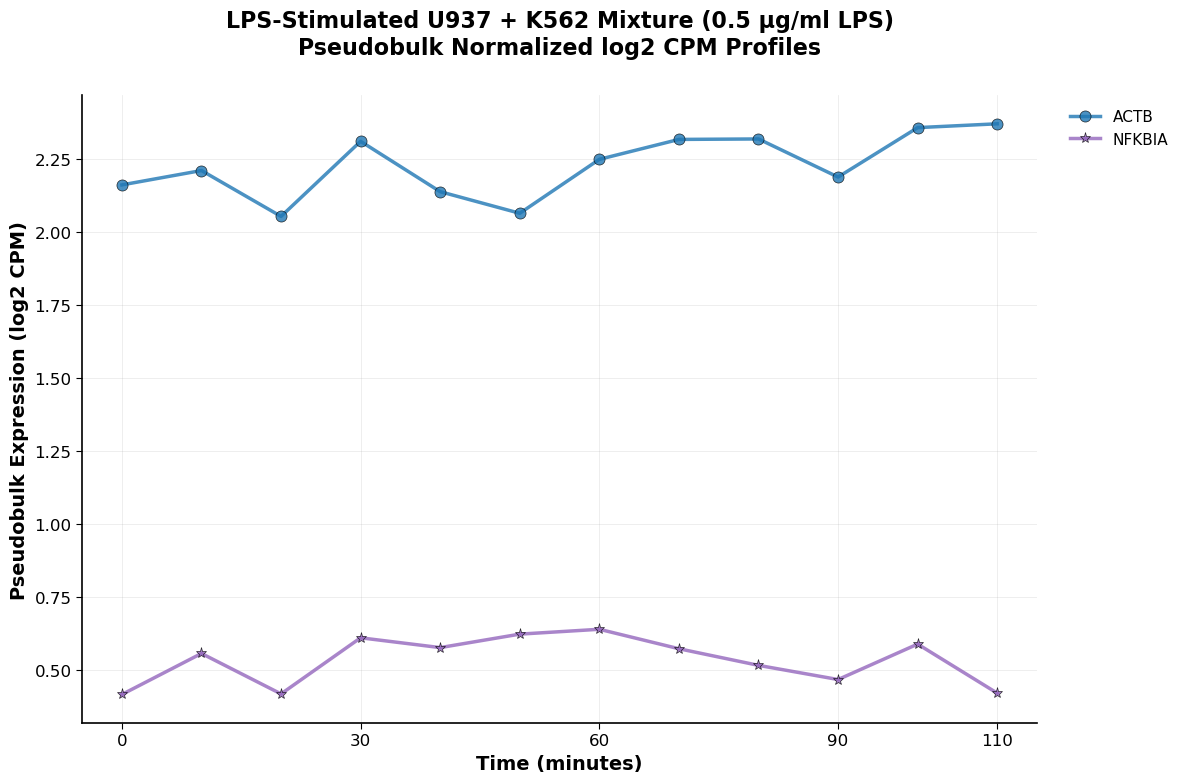


Generating plot for K562 Negative Control...


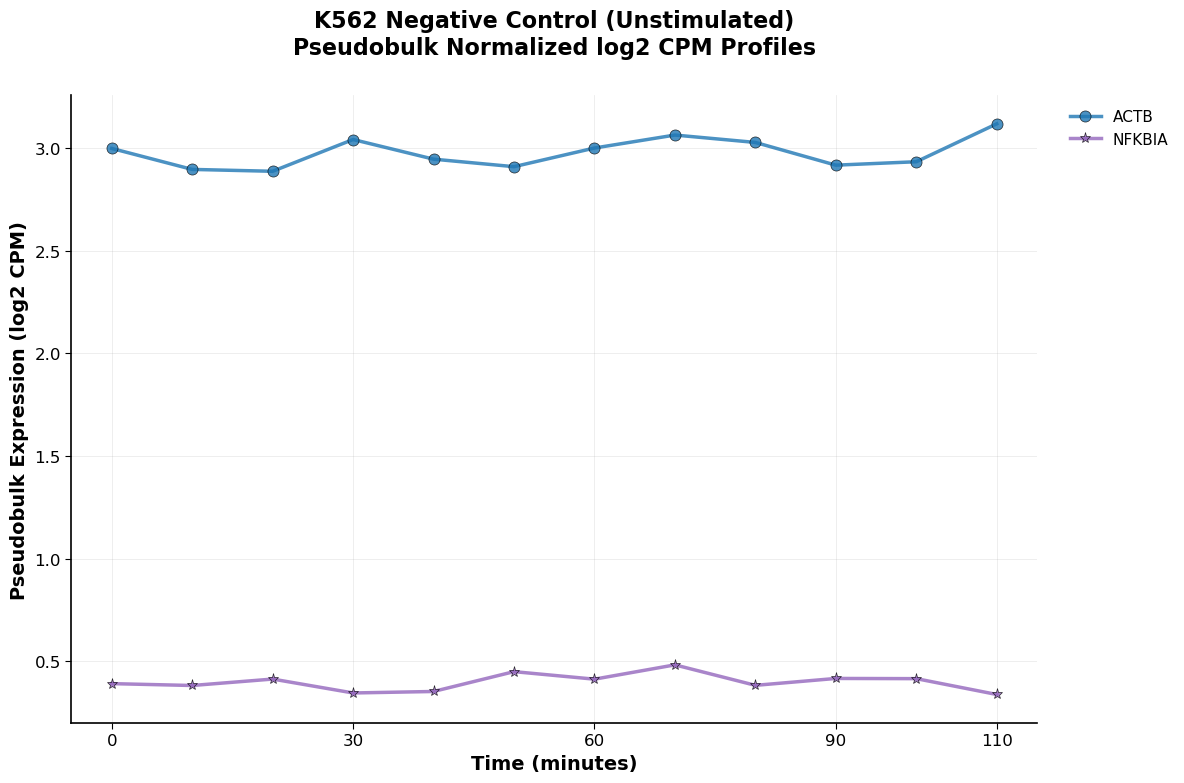


Plots saved:
- lps_stimulated_pseudobulk_timeseries.svg
- k562_negative_control_pseudobulk_timeseries.svg

Sample stimulated data (first 3 time points):
                0         1         2
ACTB    2.162656  2.211987  2.054625
NFKBIA  0.415034  0.555760  0.417063


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_pseudobulk_timeseries(df, condition_name, save_filename):
    """
    Create a time series plot of pseudobulk gene expression (log2 CPM) over time.

    Parameters:
    df: DataFrame with genes as index, time points (0-11) as columns
    condition_name: string for title and legend
    save_filename: string, filename to save the plot (SVG)
    """
    # Set publication style parameters
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'Arial',
        'axes.linewidth': 1.2,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'figure.dpi': 100,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight'
    })

    # Gene colors and markers for consistency
    gene_colors = {
        'ACTB': '#1f77b4',    # Blue - housekeeping
        'ICAM1': '#ff7f0e',   # Orange
        'IER3': '#2ca02c',    # Green
        'IL8': '#d62728',     # Red
        'NFKBIA': '#9467bd',  # Purple
        'TNFRSF9': '#8c564b'  # Brown
    }
    gene_markers = {
        'ACTB': 'o',      # Circle
        'ICAM1': 's',     # Square
        'IER3': '^',      # Triangle up
        'IL8': 'D',       # Diamond
        'NFKBIA': '*',    # Star
        'TNFRSF9': 'p'    # Pentagon
    }

    # Time points: 0 to 110 min in 10-min intervals (12 points for columns 0-11)
    time_points = np.arange(0, 120, 10)

    # Create the figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Plot each gene
    for gene in df.index:
        if gene in df.index:
            expression_values = df.loc[gene].values
            color = gene_colors.get(gene, '#808080')  # Default gray if unknown
            marker = gene_markers.get(gene, 'o')
            
            ax.plot(time_points, expression_values, 
                    color=color, marker=marker,
                    linewidth=2.5, markersize=8, alpha=0.8,
                    label=gene, markeredgecolor='black', markeredgewidth=0.5)

    # Customize plot
    ax.set_xlabel('Time (minutes)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Pseudobulk Expression (log2 CPM)', fontsize=14, fontweight='bold')
    ax.set_title(f'{condition_name}\nPseudobulk Normalized log2 CPM Profiles', 
                 fontsize=16, fontweight='bold', pad=30)

    # Set axis properties
    ax.set_xlim(-5, 115)
    ax.set_xticks([0, 30, 60, 90, 110])
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Add legend outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), 
              frameon=False, fontsize=11)

    # Adjust layout and save as SVG
    plt.tight_layout()
    plt.savefig(save_filename, format='svg', bbox_inches='tight')
    plt.show()

    return fig, ax

def load_and_plot_pseudobulk_data(stim_file, ctrl_file):
    """
    Load data from two CSV files and create separate time series plots for each condition.

    Parameters:
    stim_file: path to stimulated condition CSV (U937 + K562, LPS)
    ctrl_file: path to control condition CSV (K562 negative control)
    """
    # Load data: first column as index (gene names), columns 0-11 as time points
    df_stim = pd.read_csv(stim_file, index_col=0)
    df_ctrl = pd.read_csv(ctrl_file, index_col=0)

    # Ensure common genes and clean index
    common_genes = df_stim.index.intersection(df_ctrl.index)
    df_stim = df_stim.loc[common_genes].dropna(axis=1, how='all')  # Drop any empty columns
    df_ctrl = df_ctrl.loc[common_genes].dropna(axis=1, how='all')

    print(f"Loaded data for {len(common_genes)} common genes: {list(common_genes)}")
    print(f"Time points (columns): {list(df_stim.columns)} (assumed 0-11 = 0-110 min)")
    print(f"Stimulated data shape: {df_stim.shape}")
    print(f"Control data shape: {df_ctrl.shape}")

    # Plot for stimulated condition
    stim_filename = 'lps_stimulated_pseudobulk_timeseries.svg'
    print("\nGenerating plot for LPS-Stimulated U937 + K562...")
    fig_stim, ax_stim = plot_pseudobulk_timeseries(
        df_stim, 
        'LPS-Stimulated U937 + K562 Mixture (0.5 µg/ml LPS)', 
        stim_filename
    )

    # Plot for negative control
    ctrl_filename = 'k562_negative_control_pseudobulk_timeseries.svg'
    print("\nGenerating plot for K562 Negative Control...")
    fig_ctrl, ax_ctrl = plot_pseudobulk_timeseries(
        df_ctrl, 
        'K562 Negative Control (Unstimulated)', 
        ctrl_filename
    )

    print(f"\nPlots saved:")
    print(f"- {stim_filename}")
    print(f"- {ctrl_filename}")

    return df_stim, df_ctrl, fig_stim, fig_ctrl

# Example usage
if __name__ == "__main__":
    stim_file = 'Selected_Genes_scU937_K562.csv'
    ctrl_file = 'Selected_Genes_K562negCTRL.csv'
    
    df_stim, df_ctrl, fig_stim, fig_ctrl = load_and_plot_pseudobulk_data(
        stim_file, ctrl_file
    )
    
    # Optional: Print sample data
    print("\nSample stimulated data (first 3 time points):\n", df_stim.iloc[:, :3])
